In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Task 1 Classification on the ‘credit-g’ dataset

In [3]:
data = fetch_openml('credit-g', as_frame=False)
data

{'data': array([['<0', 6, 'critical/other existing credit', ..., 1, 'yes', 'yes'],
        ['0<=X<200', 48, 'existing paid', ..., 1, 'none', 'yes'],
        ['no checking', 12, 'critical/other existing credit', ..., 2,
         'none', 'yes'],
        ...,
        ['no checking', 12, 'existing paid', ..., 1, 'none', 'yes'],
        ['<0', 45, 'existing paid', ..., 1, 'yes', 'yes'],
        ['0<=X<200', 45, 'critical/other existing credit', ..., 1, 'none',
         'yes']], dtype=object),
 'target': array(['good', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good',
        'good', 'bad', 'bad', 'bad', 'good', 'bad', 'good', 'bad', 'good',
        'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
        'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good',
        'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad',

In [4]:
X = data["data"]
y = data["target"]
features = data["feature_names"]

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
categorical_columns = list(data["categories"].keys())
continuous_columns = list(set(features) - set(categorical_columns))
category_values = list(data["categories"].values())

In [7]:
categorical_columns_index = [i for i,v in enumerate(features) if(v in categorical_columns)]
continuous_columns_index = [i for i,v in enumerate(features) if(v in continuous_columns)]

In [8]:
print("- Following is the list of continuous features:")
print(continuous_columns)
print()
print("- Following is the list of categorical features:")
print(categorical_columns)

- Following is the list of continuous features:
['installment_commitment', 'duration', 'age', 'num_dependents', 'existing_credits', 'residence_since', 'credit_amount']

- Following is the list of categorical features:
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']


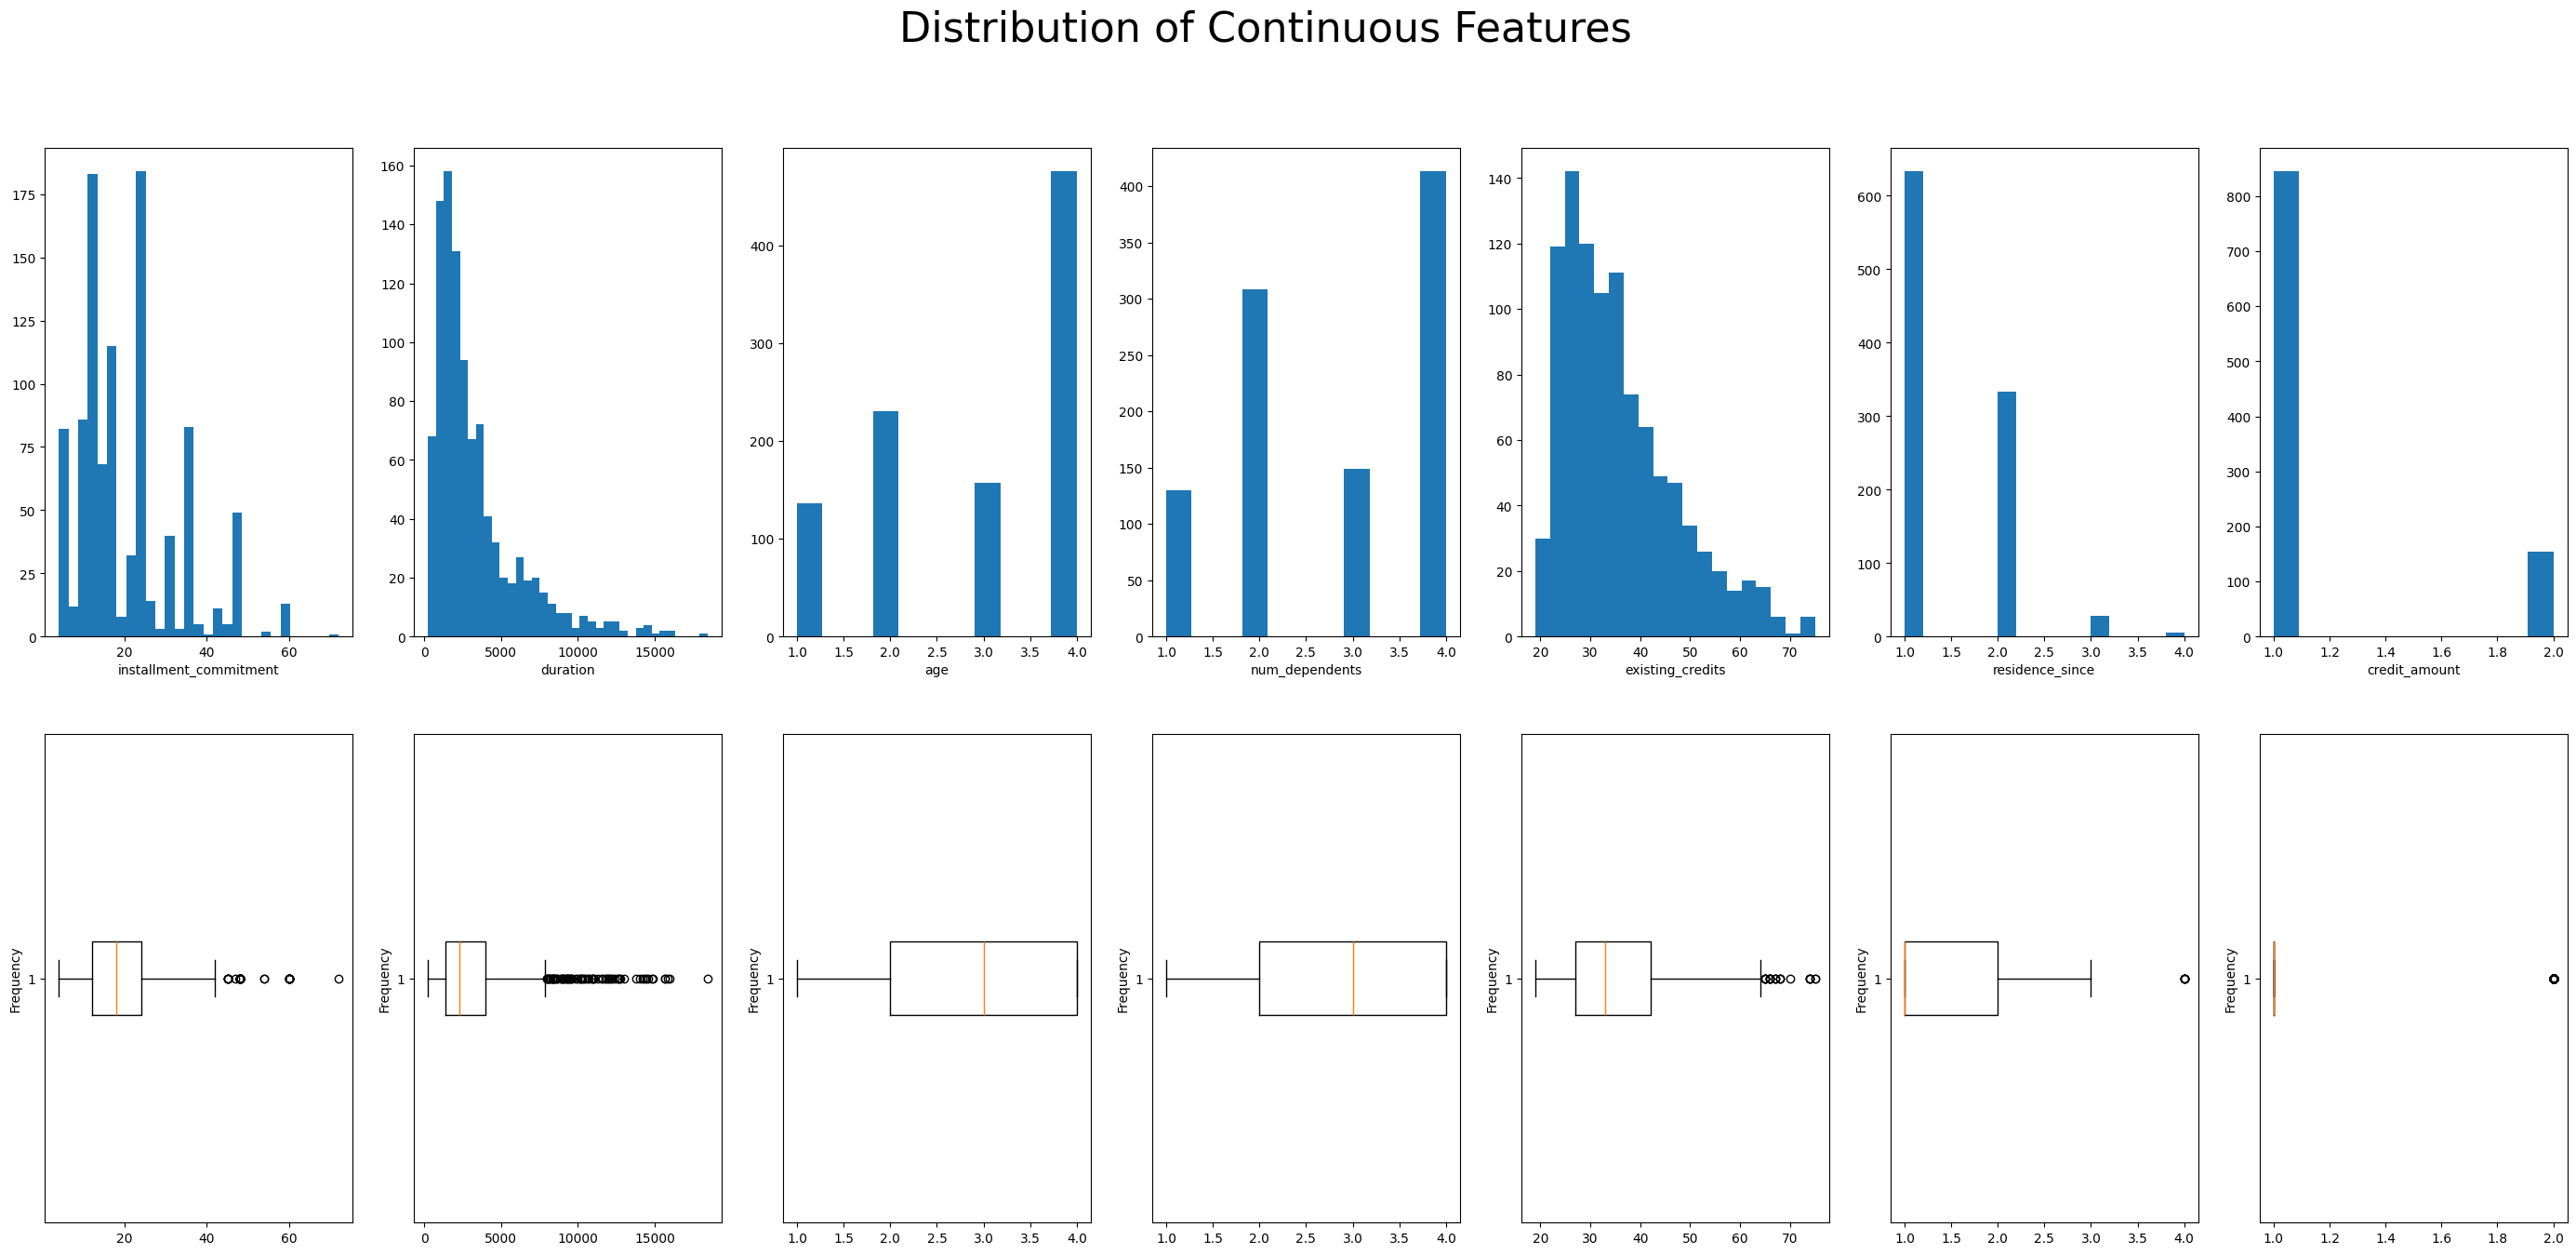

In [9]:
fig, axes = plt.subplots(2, len(continuous_columns_index) , figsize=(35, 15))

for i in range(len(continuous_columns_index)):
    axes[0,i].hist(X[:,continuous_columns_index[i]],bins = "auto")
    axes[1,i].boxplot(X[:,continuous_columns_index[i]], vert=False)
    axes[0,i].set_xlabel(continuous_columns[i])
    axes[1,i].set_ylabel("Frequency")

fig.suptitle("Distribution of Continuous Features", fontsize=32)
plt.show()

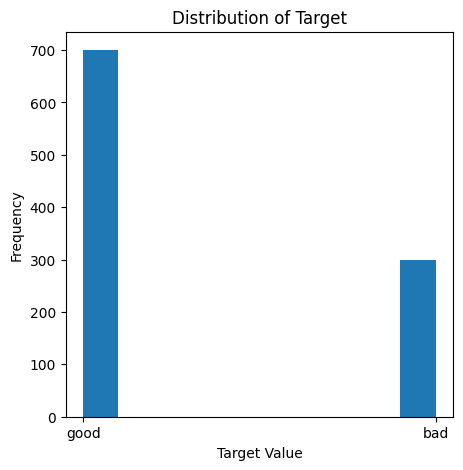

In [10]:
fig, axes = plt.subplots(figsize=(5, 5))
axes.hist(y)
axes.set_xlabel("Target Value")
axes.set_ylabel("Frequency")
axes.set_title("Distribution of Target")

plt.show()

In [11]:
X_df = pd.DataFrame(X, columns = features)
y_df = pd.DataFrame(y, columns = ["target"])

In [12]:
X_df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,4,real estate,31,none,own,1,unskilled resident,1,none,yes
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,4,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,4,car,38,none,own,1,skilled,1,none,yes
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,4,no known property,23,none,for free,1,skilled,1,yes,yes


In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

In [15]:
ohe = OneHotEncoder(handle_unknown="ignore")
ohe = ohe.fit(X_train)
X_train_preprocessed = ohe.transform(X_train)
X_val_preprocessed = ohe.transform(X_val)

In [16]:
log_reg = LogisticRegression(random_state = 42)

In [17]:
log_reg.fit(X_train_preprocessed,y_train)

LogisticRegression(random_state=42)

In [18]:
score = log_reg.score(X_val_preprocessed,y_val)
print("The validation score for Logistic Regression is: " + str(score))

The validation score for Logistic Regression is: 0.7375


In [19]:
model_names = ["LogisticRegression", "LinearSVC", "KNeighboursClassifier"]
model_list = [LogisticRegression(), LinearSVC(max_iter=5000), KNeighborsClassifier()]

In [20]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),remainder="passthrough")

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for LogisticRegression is 0.7387499999999999
The validation score for LinearSVC is 0.5475
The validation score for KNeighboursClassifier is 0.6537499999999999


In [21]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for LogisticRegression is 0.74375
The validation score for LinearSVC is 0.74375
The validation score for KNeighboursClassifier is 0.7324999999999999


We can see that the scaling helps a lot in the case of KNearestNeighbours classifier which is quite intutive from the fact that it relies upon the distances and use them intensively for the prediction of the class.

In [22]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score:0.8
The best method along with its parameter values is: {'classfier': LinearSVC(random_state=42), 'classfier__C': 0.046415888336127795}


In [23]:
plots = pd.DataFrame(grid.cv_results_)
plots["LR"]= [isinstance(plots["param_classfier"][i],LogisticRegression) for i in range(plots.shape[0])]
plots["SVM"] = [isinstance(plots["param_classfier"][i],LinearSVC) for i in range(plots.shape[0])]
plots["KNN"] = [isinstance(plots["param_classfier"][i],KNeighborsClassifier) for i in range(plots.shape[0])]

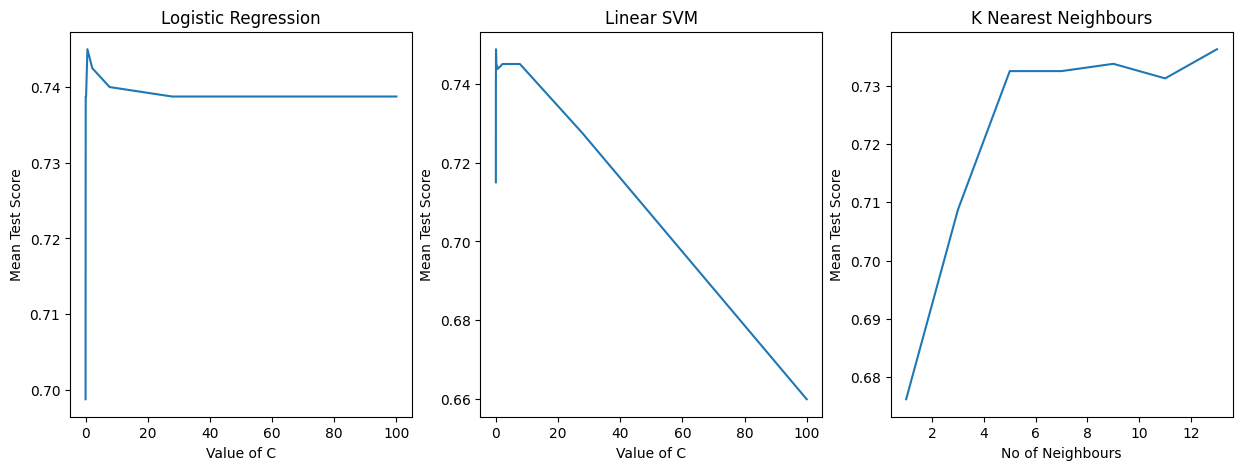

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(plots[plots["LR"]]["param_classfier__C"],plots[plots["LR"]]["mean_test_score"])
axes[1].plot(plots[plots["SVM"]]["param_classfier__C"],plots[plots["SVM"]]["mean_test_score"])
axes[2].plot(plots[plots["KNN"]]["param_classfier__n_neighbors"],plots[plots["KNN"]]["mean_test_score"])
axes[0].set_xlabel("Value of C")
axes[0].set_ylabel("Mean Test Score")
axes[0].set_title("Logistic Regression")

axes[1].set_xlabel("Value of C")
axes[1].set_ylabel("Mean Test Score")
axes[1].set_title("Linear SVM")

axes[2].set_xlabel("No of Neighbours")
axes[2].set_ylabel("Mean Test Score")
axes[2].set_title("K Nearest Neighbours")

plt.show()

In [30]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=100))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score (on the test):0.73
The best method along with its parameter values is: {'classfier': LinearSVC(random_state=42), 'classfier__C': 7.742636826811277}


In [31]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=42))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score (on the test):0.72
The best method along with its parameter values is: {'classfier': LogisticRegression(random_state=42), 'classfier__C': 0.5994842503189409}


In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=83)

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=42))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score (on the test):0.72
The best method along with its parameter values is: {'classfier': LogisticRegression(random_state=42), 'classfier__C': 0.5994842503189409}


The above 3 blocks of code show that the results change with change in value of random seed. These changes are evident from change in random seed's value at both the positions (i.e.) while performing the train_test split as well as one used in the KFold method to indicate random shuffling.

In [33]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LogisticRegression(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best parameter values for Logistic Regression: " + str(grid.best_params_))

The best parameter values for Logistic Regression: {'classifier__C': 7.742636826811277}


In [38]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LogisticRegression(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best parameter values for Logistic Regression: " + str(grid.best_params_))

The best parameter values for Logistic Regression: {'classifier__C': 7.742636826811277}


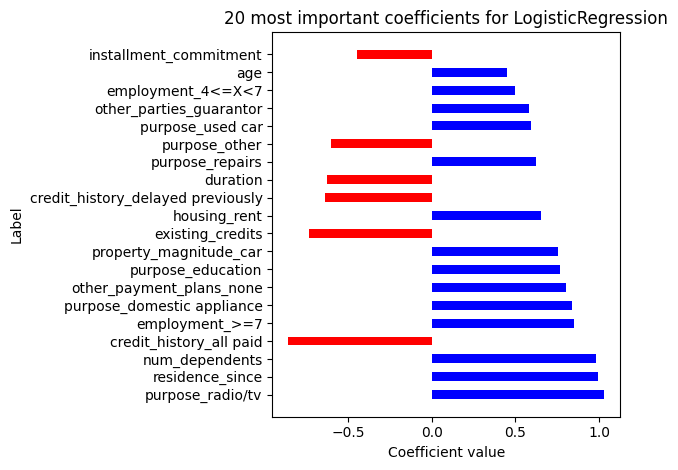

In [54]:
pipe = Pipeline([('scaler', preprocess),('classifier', LogisticRegression(C=grid.best_params_["classifier__C"]))])
pipe.fit(X_train_val,y_train_val)

coefficients=pipe.get_params()['classifier'].coef_
cat_names= list(preprocess.named_transformers_['onehotencoder'].get_feature_names_out())
features = continuous_columns.copy()
features.extend(cat_names)

coefficient_list = list(coefficients[0])

# combined_list = [(i,j) for i,j in zip(coefficient_list,features)]
# sorted_combination =sorted(combined_list, key = lambda x: abs(x[0]),reverse=True)
# top_20 = sorted_combination[:20]

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for LogisticRegression")
plt.tight_layout()

In [55]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LinearSVC(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)

grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best parameter values for Linear SVM: " + str(grid.best_params_))

The best parameter values for Linear SVM: {'classifier__C': 0.5994842503189409}


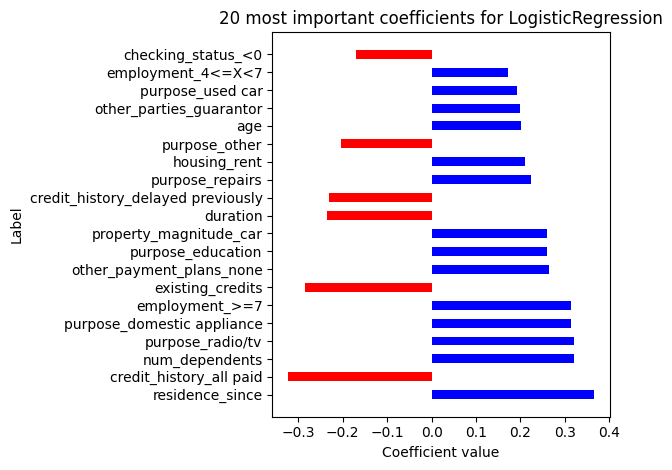

In [56]:
pipe = Pipeline([('scaler', preprocess),('classifier', LinearSVC(C=grid.best_params_["classifier__C"]))])
pipe.fit(X_train_val,y_train_val)

coefficients=pipe.get_params()['classifier'].coef_
cat_names= list(preprocess.named_transformers_['onehotencoder'].get_feature_names_out())
features = continuous_columns.copy()
features.extend(cat_names)

coefficient_list = list(coefficients[0])

# combined_list = [(i,j) for i,j in zip(coefficient_list,features)]
# sorted_combination =sorted(combined_list, key = lambda x: abs(x[0]),reverse=True)
# top_20 = sorted_combination[:20]

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for LogisticRegression")
plt.tight_layout()

# Task 2 Regression on Sydney Dataset